# 1. Convert Behavioral Output File to Required Trial-by-Trial Format
Here, we convert the behavioral data into a useable format, where each row of the DataFrame corresponds to a trial. This can then be aligned with Ca2+ data.
### A. Setup
Make sure you have the correct .py files in your directory! You need Hongli's version of behavior_base, behavioral_pipeline, and behavioral_albert_MKedits. In the following section, we borrow functions from these scripts

In [2]:
from behavior_base import *
import pyPlotHW
import utility_HW
from behavioral_pipeline import GoNogoBehaviorMat
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
from pyPlotHW import *
from scipy.stats import binomtest
import matplotlib.patches as mpatches

In [293]:
# Specify session to analyze
animal = 'JUV022'
session = '230124'

In [294]:
# Grab file from server
input_folder = fr"\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\processed_data\Data\{animal}\{session}"
input_file = fr"{animal}_{session}_behaviorLOG.mat"
hfile = h5py.File(os.path.join(input_folder, input_file), 'r')

In [295]:
# format trial events
eventlist = EventNode(None, None, None, None)
code_map = GoNogoBehaviorMat.code_map
trial_events = np.array(hfile['out/GoNG_EventTimes'])

### B. Convert data into TrialByTrial format


In [296]:
for i in range(len(trial_events)):
    eventID, eventTime, trial = trial_events[i]
    eventlist.append(EventNode(code_map[eventID][0] + '|' + code_map[eventID][1], eventTime, trial, eventID))

In [297]:
trialbytrial = GoNogoBehaviorMat(animal, session, os.path.join(input_folder, input_file))
behavior = trialbytrial.to_df() 

In [298]:
# add extra columns to find the lick time relative to the trial start time
adjusted = []
firstlick = []
for index, trial in behavior.iterrows():
    onset_time = trial['onset']
    trial_licks = trial['licks']
    adjusted.append([lick - onset_time for lick in trial_licks])
    firstlick.append(trial['first_lick_in'] - onset_time)
behavior['adjusted_licks'] = adjusted
behavior['adjusted_firstlick'] = firstlick

In [299]:
# save csv file
behavior.to_csv(fr"Z:\Madeline\processed_data\Data\{animal}\{session}\{animal}_{session}_behavior_output.csv")

# 2. Alignment of Ca2+ Signal and Plotting

### A. Setup

In [233]:
from behavioral_albert_MKedits import *
# NOTE: this is a locally saved file, available on Hongli's github 
logging.getLogger().setLevel(logging.WARNING)
%matplotlib inline

In [234]:
from tqdm import tqdm
from fluorescent_pipeline import Suite2pSeries

In [235]:
data_root = r'Z:\Madeline\processed_data\Data'
from behavioral_albert_MKedits import GoNoGo_Expr
gse = GoNoGo_Expr(data_root)

Changing plot_path as Z:Madeline\processed_data\plots


### B. Calculate dF/F and align behavioral data

In [275]:
# using functions from Albert's scripts to calculate dF/F
filemap = gse.encode_to_filename(animal, session, ['suite2p', 'log', 'trial'])
print(filemap['suite2p'])
gn_seris = Suite2pSeries(filemap['suite2p'])

Z:\Madeline\processed_data\Data\JUV017\221026\suite2p
Calculating dFFs........


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:08<00:00,  7.23it/s]


In [ ]:
# align dF/F to behavior and save files
# if you get an error here, likely the number of matlab frames differs from the actual number of frames
# see "Preprocessing imaging data & aligning to behavioral data" section in the
# Behavioral Protocol and Experimental Details" document (available on the server under Madeline and on bcourses)
gn_seris.realign_time(trialbytrial)
dff = gn_seris.neural_df
behavior.to_csv(fr"Z:\Madeline\processed_data\Data\{animal}\{session}\{animal}_{session}_behavior_output.csv")
dff.to_csv(fr"Z:\Madeline\processed_data\Data\{animal}\{session}\{animal}_{session}_fluor.csv")
dFF_aligned, run_aligned = align_Ca2data(behavior,dff, -2, 2, 0.05, 'onset')

In [6]:
# reformat data to input into multiple linear regression in the next section
# this code is from Hongli

def align_Ca2data(tbtDF, dff, startTime, endTime, step, event):
    
    nCells = dff.shape[1] - 1
    nTrials = tbtDF.shape[0]
    interpT = np.arange(startTime, endTime, step)

    dFFaligned = np.zeros((len(interpT), nTrials, nCells))
    run_aligned = np.zeros((len(interpT), nTrials))
    
    for tt in range(nTrials):
        
        speed = np.array(tbtDF['running_speed'][tt])
        speed_time = np.array(tbtDF['running_time'][tt])
        if speed.size != 0:
            t = speed_time - tbtDF['onset'][tt]
            y = speed
            run_aligned[:, tt] = np.interp(interpT, t, y)
        
        if np.isnan(tbtDF[event].iloc[tt]):
            event = 'onset'
        tempStart = tbtDF[event].iloc[tt] + startTime
        tempEnd = tbtDF[event].iloc[tt] + endTime
        t_dFF =  dff['time'].values
        for cc in range(nCells):
            dFF = dff['neuron'+str(cc)].values
                    # get the trial timing
            tempT = t_dFF[np.logical_and(t_dFF>tempStart, t_dFF<=tempEnd)]-tbtDF[event].iloc[tt]
            tempdFF = dFF[np.logical_and(t_dFF>tempStart, t_dFF<=tempEnd)]
                    # interpolate
            if len(tempdFF)>0:
                dFFaligned[:,tt,cc] = np.interp(interpT, tempT, tempdFF)
                
    return dFFaligned, run_aligned

In [138]:
dFF_aligned, run_aligned = align_Ca2data(behavior,dff, -2, 2, 0.05, 'onset') # aligns data to onset of trial

# 3. Multiple Linear Regression
Here we implement Hongli's MLR. The code below is adapted from his code and adjusted slightly for our data format. The first cell is just specifying the functions.

### A. Define Functions

In [9]:
from fluorescent_pipeline import fluoAnalysis

def process_X(regr_time, choiceList, rewardList, nTrials, nCells, trial, dFF, running):
    # re-arrange the behavior and dFF data for linear regression
    X = np.zeros((14,len(regr_time)))
    Y = np.zeros((nCells, len(regr_time)))

    # need to determine whether to use exact frequency or go/no go/probe
    # separate into go/no go trials (for probe trials: 9-12: go; 13-16 no go
    # previous + next stimulus
    go_stim = [1,2,3,4,9,10,11,12]
    nogo_stim = [5,6,7,8,13,14,15,16]

    X[1, :] = np.ones(len(regr_time)) * [1 if behavior['sound_num'][trial] in go_stim else 0]
    if trial == 0:
        X[2,:] = np.ones(len(regr_time)) * np.nan
    else:
        X[2, :] = np.ones(len(regr_time)) * [1 if behavior['sound_num'][trial-1] in go_stim else 0]
    if trial == nTrials-1:
        X[0, :] = np.ones(len(regr_time)) * np.nan
    else:
        X[0, :] = np.ones(len(regr_time)) * [1 if behavior['sound_num'][trial+1] in go_stim else 0]

    # choice: lick = 1; no lick = -1
    X[3, :] = np.ones(len(regr_time)) * (choiceList[trial + 1] if trial < nTrials - 1 else np.nan)
    X[4, :] = np.ones(len(regr_time)) * (choiceList[trial])
    X[5, :] = np.ones(len(regr_time)) * (choiceList[trial - 1] if trial > 0 else np.nan)
    # reward
    X[6, :] = np.ones(len(regr_time)) * (rewardList[trial + 1] if trial < nTrials - 1 else np.nan)
    X[7, :] = np.ones(len(regr_time)) * rewardList[trial]
    X[8, :] = np.ones(len(regr_time)) * (rewardList[trial - 1] if trial > 0 else np.nan)
    # interaction
    X[9, :] = X[3, :] * X[6, :]
    X[10, :] = X[4, :] * X[7, :]
    X[11, :] = X[5, :] * X[8, :]

    # running speed and licks
    tStep = np.nanmean(np.diff(regr_time))
    licks = behavior['licks'][trial]
    interpT = np.arange(-2, 2, 0.05) # this will need to be changed according to window

    for tt in range(len(regr_time)):
        t_start = regr_time[tt] - tStep / 2
        t_end = regr_time[tt] + tStep / 2
        temp_run = running[:, trial]
        X[12, tt] = np.nanmean(
            temp_run[np.logical_and(interpT > t_start, interpT <= t_end)])
        X[13, tt] = np.sum(np.logical_and(licks>=t_start+behavior['onset'][trial],
                                          licks<t_end+behavior['onset'][trial]))

        # dependent variable: dFF
        for cc in range(nCells):
            temp_dFF = dFF_aligned[:, trial, cc]
            Y[cc, tt] = np.nanmean(temp_dFF[np.logical_and(interpT > t_start, interpT <= t_end)])

    return X, Y

def plotMLRResult(MLRResult, labels, saveFigPath, neuronRaw):
    
    varList =labels
    nPredictors = MLRResult['coeff'].shape[0]
    coeffPlot = StartSubplots(4,4, ifSharey=True)
    maxY = 0
    minY = 0
    
    for n in range(nPredictors):
        tempBoot = bootstrap(MLRResult['coeff'][n,:,:],1, 1000)
        tempMax = max(tempBoot['bootHigh'])
        tempMin = min(tempBoot['bootLow'])
        if tempMax > maxY:
            maxY = tempMax
        if tempMin < minY:
            minY = tempMin
        coeffPlot.ax[n//4, n%4].plot(MLRResult['regr_time'], tempBoot['bootAve'], c =(0,0,0))
        coeffPlot.ax[n // 4, n % 4].fill_between(MLRResult['regr_time'], tempBoot['bootLow'], tempBoot['bootHigh'],
                                      alpha=0.2,  color = (0.7,0.7,0.7))
        coeffPlot.ax[n//4, n%4].set_title(varList[n])
    plt.ylim((minY,maxY))
    plt.show()
    coeffPlot.save_plot('Average coefficient.tif','tiff', saveFigPath)
    sigPlot = StartSubplots(4, 4, ifSharey=True)
    pThresh = 0.001
    nCell = MLRResult['coeff'].shape[2]

    for n in range(nPredictors):
        fracSig = np.sum(MLRResult['pval'][n, :, :]<pThresh,1)/nCell
        pResults = [binomtest(x,nCell,p=pThresh).pvalue for x in np.sum(MLRResult['pval'][n, :, :]<pThresh,1)]
        sigPlot.ax[n // 4, n % 4].plot(MLRResult['regr_time'], fracSig, c=(0, 0, 0))
        sigPlot.ax[n // 4, n % 4].set_title(varList[n])
        if n//4 == 0:
            sigPlot.ax[n // 4, n % 4].set_ylabel('Fraction of sig')
        if n > 8:
            sigPlot.ax[n // 4, n % 4].set_xlabel('Time from cue (s)')
        dt = np.mean(np.diff(MLRResult['regr_time']))
        for tt in range(len(MLRResult['regr_time'])):
            if pResults[tt]<0.05:
                sigPlot.ax[n//4, n%4].plot(MLRResult['regr_time'][tt]+dt*np.array([-0.5,0.5]), [0.5,0.5],color=(255/255, 189/255, 53/255), linewidth = 5)
    plt.ylim((0,0.6))
    plt.show()
    sigPlot.save_plot('Fraction of significant neurons.tif', 'tiff', saveFigPath)

    r2Boot = bootstrap(MLRResult['r2'], 1, 1000)
    r2Plot = StartPlots()
    r2Plot.ax.plot(MLRResult['regr_time'], r2Boot['bootAve'],c=(0, 0, 0))
    r2Plot.ax.fill_between(MLRResult['regr_time'], r2Boot['bootLow'], r2Boot['bootHigh'], color=(0.7, 0.7, 0.7))
    r2Plot.ax.set_title('R-square')
    r2Plot.save_plot('R-square.tif', 'tiff', saveFigPath)

    sigCells = MLRResult['sigCells']
    cellstat = []
    for cell in range(neuronRaw.Fraw.shape[0]):
        if neuronRaw.cells[cell, 0] > 0:
            cellstat.append(neuronRaw.stat[cell])
    fluoCellPlot = StartPlots()
    im = np.zeros((256, 256,3))

    for cell in range(len(cellstat)):
        xs = cellstat[cell]['xpix']
        ys = cellstat[cell]['ypix']
        if cell not in \
                set(sigCells['choice'])|set(sigCells['outcome'])|set(sigCells['stimulus']):
            im[ys, xs] = [0.5, 0.5, 0.5]

    for cell in sigCells['choice']:
        xs = cellstat[cell]['xpix']
        ys = cellstat[cell]['ypix']
        im[ys, xs] = np.add(im[ys, xs], [1.0, 0.0, 0.0])
    for cell in sigCells['outcome']:
        xs = cellstat[cell]['xpix']
        ys = cellstat[cell]['ypix']
        im[ys,xs] = np.add(im[ys,xs],[0.0,1.0,0.0])
    for cell in sigCells['stimulus']:
        xs = cellstat[cell]['xpix']
        ys = cellstat[cell]['ypix']
        im[ys,xs] = np.add(im[ys,xs],[0.0,0.0,1.0])
    action_patch = mpatches.Patch(color=(1,0,0), label='Action')
    outcome_patch = mpatches.Patch(color=(0,1,0), label = 'Outcome')
    stimulus_patch = mpatches.Patch(color=(0, 0, 1), label='Stimulus')
    plt.legend(handles=[action_patch, outcome_patch, stimulus_patch],loc='center left',bbox_to_anchor=(1, 0.5))
    fluoCellPlot.ax.imshow(im, cmap='CMRmap')
    plt.show()

    fluoCellPlot.save_plot('Regression neuron coordinates.tiff', 'tiff', saveFigPath)
    
import statsmodels.api as sm
def run_MLR(x, y, nCells, n_predictors):
    coeff = np.zeros((n_predictors, nCells))
    pval = np.zeros((n_predictors, nCells))
    rSquare = np.zeros((nCells))
    x = sm.add_constant(x)
    for cc in range(nCells):
        model = sm.OLS(y[:,cc], x[:,:]).fit() 
        coeff[:,cc] = model.params[1:] 
        pval[:,cc] = model.pvalues[1:]
        rSquare[cc] = model.rsquared
    return coeff, pval, rSquare

### B. Set up and run MLR

First, we want to see how many trials are in the behavior here. It will be the first number printed below. Remember that our behavior processing removes end trials if the animal is disengaged, so you will need to cross-reference “behavior_struct.[animal].info.num_adj_trials” with the number below.

In [35]:
behavior.shape

(271, 20)

In [36]:
n_predictors = 14
labels = ['s(n+1)','s(n)', 's(n-1)','c(n+1)', 'c(n)', 'c(n-1)',
          'r(n+1)', 'r(n)', 'r(n-1)', 'x(n+1)', 'x(n)', 'x(n-1)', 'speed', 'lick']
tStart = -2.00
tEnd = 2.00
tStep = 0.05
regr_time = np.arange(tStart, tEnd, tStep)
# NOTE: if disengaged trials were removed (see note above), specify the number of adjusted trials as nTrials
# otherwise, nTrials = behavior.shape[0]
nTrials = 185 #behavior.shape[0]
nCells = dff.shape[1]-2
independent_X = np.zeros((n_predictors, nTrials, len(regr_time)))
dFF_Y = np.zeros((nCells, nTrials, len(regr_time)))
choiceList = [1 if lick > 0 else 0 for lick in behavior['licks_out']]
rewardList = behavior['reward']

In [ ]:
# create matrices for use in MLR (Hongli's code)
X = [] 
y = []
for trial in tqdm(range(nTrials)):
    X.append(process_X(regr_time, choiceList, rewardList, nTrials, nCells, trial, dFF_aligned, run_aligned)[0])
    y.append(process_X(regr_time, choiceList, rewardList, nTrials, nCells, trial, dFF_aligned, run_aligned)[1])
X = np.array(X)
y = np.array(y)

Sometimes the first or last trials don't have imaging data. Print them below to check. If there are any nan values, we can't use that trial. You may need to run this cell multiple times to check the first few and last several trials.

In [ ]:
print(X[1])
print(y[1])
print(X[len(X)-1])
print(y[len(y)-1])

If you still get an error, images might have stopped in the middle of the behavior session. Use the code below to see if there are nans in the middle of the session:

In [ ]:
#np.argwhere(np.isnan(X[:,:,0]))

If not all trials have images (i.e., you have nans anywhere in X or y), you will need to manually edit the definition below to exclude trials without images.
In the first for loop, edit "run_MLR" to specify the range of the X and y matrices.

In [29]:
from utility_HW import bootstrap, count_consecutive
def linear_regr(X, y, nCells, n_predictors, regr_time, saveDataPath):

    MLRResult = {'coeff': np.zeros((n_predictors, len(regr_time), nCells)), 
                 'pval': np.zeros((n_predictors, len(regr_time), nCells)), 
                 'r2': np.zeros((len(regr_time), nCells)), 'regr_time': regr_time}
    
    # edit the right hand side of the equation below depending on 
    # i.e., if images start at trial 2 and end at the second-to-last trial, put in:
    # run_MLR(X[1:-1,:,tt],y[1:-1,:,tt], ...) otherwise, run_MLR(X[:,:,tt],y[:,:,tt], ... ) to include all trials
    for tt in tqdm(range(len(regr_time))):
        MLRResult['coeff'][:,tt,:], MLRResult['pval'][:,tt,:], MLRResult['r2'][tt,:] = run_MLR(X[1:-2,:,tt],y[1:-2,:,tt], nCells, n_predictors)

    sigCells = {}
    sigCells['stimulus'] = []
    sigCells['choice'] = []
    sigCells['outcome'] = []
    pThresh = 0.01
    for cc in range(nCells):
        stiPVal = MLRResult['pval'][1,:,cc]
        choicePVal = MLRResult['pval'][4,:,cc]
        outcomePVal = MLRResult['pval'][7,:,cc]
        if sum(stiPVal<0.01) >= 10 or count_consecutive(stiPVal<0.01)>=3:
            sigCells['stimulus'].append(cc)
        if sum(choicePVal < 0.01) >= 10 or count_consecutive(choicePVal < 0.01) >= 3:
            sigCells['choice'].append(cc)
        if sum(outcomePVal < 0.01) >= 10 or count_consecutive(outcomePVal < 0.01) >= 3:
            sigCells['outcome'].append(cc)

    MLRResult['sigCells'] = sigCells
    
    with open(saveDataPath, 'wb') as pf:
        pickle.dump(MLRResult, pf, protocol=pickle.HIGHEST_PROTOCOL)
        pf.close()
        
    return MLRResult

Now you can run the MLR and save the results!

In [39]:
import pickle
from pathlib import Path
saveDataPath = Path(fr'Z:\Madeline\processed_data\Analysis\{animal}\{session}\{animal}-{session}-MLR.pickle')
saveFigPath = Path(fr'Z:\Madeline\processed_data\Analysis\{animal}\{session}\{animal}-{session}-fluo_plot')
saveDataPath.parent.mkdir(exist_ok=True, parents=True)
saveFigPath.parent.mkdir(exist_ok=True, parents=True)
MLRResult = linear_regr(X, y, nCells, n_predictors, regr_time, saveDataPath)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:14<00:00,  5.71it/s]


In [ ]:
# plot output
plotMLRResult(MLRResult, labels, saveFigPath, gn_seris)

# 4. Examining MLR Results

First we write some code to parse cells deemed "significant" in Hongli's code for stimulus, choice, and outcome. We want to only select cells that are uniquely significant for each of those variables. Then we define another function that defines what it means to be significant for licking and running.

Note that my function for parsing stimulus, choice, and outcome cells returns lists of cells, whereas my function for licking and running returns the fraction of cells. I don't know why I did it this way but here we are. We're ultimately interested in the fraction of significant cells, so this means that later in the code, I'll have to add extra lines to calculate the fraction for stimulus, choice, and outcome significant cells. You can rewrite it if you want so they match.

In [42]:
import glob

# identifies cells that are uniquely significant for just one of the three variables
# returns lists of those cells
def sort_sigCells(MLRoutput):
    stim = MLRoutput['sigCells']['stimulus']
    choice = MLRoutput['sigCells']['choice']
    outcome = MLRoutput['sigCells']['outcome']
    stim_cells = []
    choi_cells = []
    outc_cells = []
    for cell in stim:
        if cell not in choice and cell not in outcome:
            stim_cells.append(cell)
    for cell in choice:
        if cell not in stim and cell not in outcome:
            choi_cells.append(cell)
    for cell in outcome:
        if cell not in choice and cell not in stim:
            outc_cells.append(cell)
    return stim_cells, choi_cells, outc_cells
    
# defines significance for lick and run responsive cells
# returns the fraction of lick and run responsive cells
def lick_run_sig(MLRoutput):
    lickcells = []
    runcells = []
    for cell in range(0,MLRoutput['pval'].shape[2]):
        licksig = np.zeros(MLRoutput['pval'].shape[1])
        runsig = np.zeros(MLRoutput['pval'].shape[1])
        for time in range(0,MLRoutput['pval'].shape[1]):
            if MLRoutput['pval'][13][time][cell] < 0.01:
                licksig[time] = 1
            if MLRoutput['pval'][12][time][cell] < 0.01:
                runsig[time] = 1
        for x in range(0,MLRoutput['pval'].shape[1]-3):
            if cell not in lickcells and sum(licksig[x:x+3]) > 2:
                lickcells.append(cell)
            if cell not in runcells and sum(runsig[x:x+3]) > 2:
                runcells.append(cell)
        if cell not in lickcells and sum(licksig[40:]) > 10:
            lickcells.append(cell)
        if cell not in runcells and sum(runsig[40:]) > 10:
            runcells.append(cell)
    lickfrac = len(lickcells)/MLRoutput['pval'].shape[2]
    runfrac = len(runcells)/MLRoutput['pval'].shape[2]
    return lickfrac, runfrac

if we just want to look at one animal, we can use the cell below:

In [ ]:
animal = 'JUV016'
session = '220409'

input_folder = fr"Z:\Madeline\processed_data\Analysis\{animal}\{session}"
picklefile = os.path.join(input_folder, "*MLR.pickle")
mlr = glob.glob(picklefile)
with open(mlr[0], 'rb') as f:
    MLR = pickle.load(f)
    
lick_fraction, run_fraction = lick_run_sig(MLR)
stim_cells, choice_cells, out_cells = sort_sigCells(MLR)

Or to run all our data, use this big ol' loop:

In [52]:
exp_folder = r"\\filenest.diskstation.me\Wilbrecht_file_server\HongliWang\Madeline\Nonlearning_Late\Data"
ADTrun = []
JUVrun = []
ADTlick = []
JUVlick = []
ADTstim = []
ADTchoice = []
ADToutcome = []
JUVstim = []
JUVchoice = []
JUVoutcome = []
for animal in os.listdir(exp_folder):
    animal_path = os.path.join(exp_folder,animal)
    for session in os.listdir(animal_path):
        session_path = os.path.join(animal_path,session)
        if os.path.isdir(os.path.join(session_path,'suite2p')):
            input_folder = fr"\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\processed_data\Analysis\{animal}\{session}"
            picklepath = os.path.join(input_folder, "*MLR.pickle")
            MLRfile = glob.glob(picklepath)
            print(animal, session)
            with open(MLRfile[0], 'rb') as f:
                MLRoutput = pickle.load(f)
            lick, run = lick_run_sig(MLRoutput)
            sig_cells = sort_sigCells(MLRoutput)
            if 'ADT' in animal or 'TRA' in animal:
                ADTlick.append(lick)
                ADTrun.append(run)
                ADTstim.append(len(sig_cells[0])/MLRoutput['coeff'].shape[2])
                ADTchoice.append(len(sig_cells[1])/MLRoutput['coeff'].shape[2])
                ADToutcome.append(len(sig_cells[2])/MLRoutput['coeff'].shape[2])
            elif 'JUV' in animal:
                JUVlick.append(lick)
                JUVrun.append(run)
                JUVstim.append(len(sig_cells[0])/MLRoutput['coeff'].shape[2])
                JUVchoice.append(len(sig_cells[1])/MLRoutput['coeff'].shape[2])
                JUVoutcome.append(len(sig_cells[2])/MLRoutput['coeff'].shape[2])

ADT015 230223
ADT015 230224
ADT015 230225
JUV020 230201
JUV020 230203
JUV021 230201
JUV021 230202


What's printed below can be copied and pasted into Prism for further analysis:

In [53]:
print("ADT:")
print(ADTstim)
print(ADToutcome)
print(ADTchoice)
print(ADTlick)
print("JUV:")
print(JUVstim)
print(JUVoutcome)
print(JUVchoice)
print(JUVlick)

ADT:
[0.028985507246376812, 0.09375, 0.031746031746031744]
[0.043478260869565216, 0.01875, 0.031746031746031744]
[0.033816425120772944, 0.1125, 0.037037037037037035]
[0.0, 0.0125, 0.021164021164021163]
JUV:
[0.0, 0.0, 0.013986013986013986, 0.012987012987012988]
[0.0, 0.011627906976744186, 0.027972027972027972, 0.025974025974025976]
[0.10204081632653061, 0.06976744186046512, 0.06993006993006994, 0.09090909090909091]
[0.02040816326530612, 0.0, 0.0, 0.0]


Or run individual stat tests here:

In [ ]:
import scipy.stats
scipy.stats.mannwhitneyu(ADTlick,JUVlick)

# 5. Plotting neuron activity from saved dataframes

In [7]:
# let's just look at one session
import glob
import pickle

animal = 'JUV016'
session = '220409'
input_folder = fr"Z:\Madeline\processed_data\Analysis\{animal}\{session}"

picklefile = os.path.join(input_folder, "*MLR.pickle")
mlr = glob.glob(picklefile)
with open(mlr[0], 'rb') as f:
    MLR = pickle.load(f)

In [8]:
# how many cells are in this session?
totalcells = MLR['coeff'].shape[2]

# let's look at stimulus-responsive neurons
stimcells = MLR['sigCells']['stimulus']
stimcells

[15,
 19,
 21,
 53,
 72,
 100,
 109,
 117,
 121,
 125,
 126,
 129,
 140,
 144,
 150,
 154,
 184,
 186,
 195]

Python orders our neurons' numbers alphabetically (1, 10, 11, instead of 1, 2, 3). The next two cells allow us to find which alphabetical numerations correspond to chronological numbers. That way we can cross-reference a particular neuron of interest between the MLR output and the dFF dataframes previously generated.

In [ ]:
def find_neurons(neuron_range, num):
    alph_neurons = sorted(neuron_range, key=str)
   # key = alph_neurons[num] # convert from "neuronX" in dataframes to X in MLR list
    key = alph_neurons.index(num) # convert from X in MLR list to "neuronX" in behavior and dFF dataframes
    return key

In [ ]:
neurons = []
for neuron in stimcells:
    key = find_neurons(list(range(0,totalcells)), neuron)
    neurons.append(key)
    print("neuron", neuron, " is: ", key)

If we already have our dataframes previously formatted and saved, we can load them to analyze neuron activity. Here's a modified version of a function we used before that will take in previously generated dataframes and align our neural data to cue onset:

In [9]:
def align_Ca2data2(tbtDF, dff, startTime, endTime, step, event):
    
    nCells = dff.shape[1] - 1
    nTrials = tbtDF.shape[0]
    interpT = np.arange(startTime, endTime, step)

    dFFaligned = np.zeros((len(interpT), nTrials, nCells))
    run_aligned = np.zeros((len(interpT), nTrials))
    count = 0
    
    for index, trial in tbtDF.iterrows():
        
        speed = np.array(trial['running_speed'])
        speed_time = np.array(trial['running_time'])
        if speed.size != 0:
            t = speed_time - trial['onset']
            y = speed
            run_aligned[:, count] = np.interp(interpT, t, y)
        
        tempStart = trial[event] + startTime
        tempEnd = trial[event] + endTime
        t_dFF =  dff['time'].values
        
        for cc in range(nCells):
            dFF = dff['neuron'+str(cc)].values
                    # get the trial timing
            tempT = t_dFF[np.logical_and(t_dFF>tempStart, t_dFF<=tempEnd)]-trial[event]
            tempdFF = dFF[np.logical_and(t_dFF>tempStart, t_dFF<=tempEnd)]
                    # interpolate
            if len(tempdFF)>0:
                dFFaligned[:,count,cc] = np.interp(interpT, tempT, tempdFF)
        count += 1
                
    return dFFaligned

Now we can load in the dff and behavior dataframes of our session:

In [10]:
dff = pd.read_csv(fr"Z:\Madeline\processed_data\Data\{animal}\{session}\{animal}_{session}_fluor.csv")
behavior =  pd.read_csv(fr"Z:\Madeline\processed_data\Data\{animal}\{session}\{animal}_{session}_behavior_output.csv")
from ast import literal_eval
behavior[['licks','running_speed','running_time','adjusted_licks']] = behavior[['licks','running_speed','running_time','adjusted_licks']].applymap(literal_eval)

# formatting
behavior = behavior.drop('Unnamed: 0', axis=1)
dff = dff.drop('Unnamed: 0', axis = 1)

Now we filter the types of trials we're interested in (there are a lot of possibilities for plotting):

In [11]:
# sort by go vs. no-go
go = behavior[behavior['go_nogo']=='go']
nogo = behavior[behavior['go_nogo']=='nogo']
dFF_go = align_Ca2data2(go, dff, -2, 2, 0.05, 'onset') # aligns data to onset, but sorts trials by first lick time
dFF_nogo = align_Ca2data2(nogo, dff, -2, 2, 0.05, 'onset')

# sort by go vs. no-go, and then sort trials by first lick time
go_firstlick = go.sort_values('adjusted_firstlick') # sort dataframe by fastest lick
nogo_firstlick = nogo.sort_values('adjusted_firstlick')
dFF_go_lick = align_Ca2data2(go_firstlick, dff, -2, 2, 0.05, 'onset') # aligns data to onset, but sorts trials by first lick time
dFF_nogo_lick = align_Ca2data2(nogo_firstlick, dff, -2, 2, 0.05, 'onset')

# sort by cue 
cue1 = behavior[behavior['sound_num']==1]
cue2 = behavior[behavior['sound_num']==2]
cue3 = behavior[behavior['sound_num']==3]
cue4 = behavior[behavior['sound_num']==4]
cue5 = behavior[behavior['sound_num']==5]
cue6 = behavior[behavior['sound_num']==6]
cue7 = behavior[behavior['sound_num']==7]
cue8 = behavior[behavior['sound_num']==8]
dFF_1 = align_Ca2data2(cue1, dff, -2, 2, 0.05, 'onset')
dFF_2 = align_Ca2data2(cue2, dff, -2, 2, 0.05, 'onset')
dFF_3 = align_Ca2data2(cue3, dff, -2, 2, 0.05, 'onset')
dFF_4 = align_Ca2data2(cue4, dff, -2, 2, 0.05, 'onset')
dFF_5 = align_Ca2data2(cue5, dff, -2, 2, 0.05, 'onset')
dFF_6 = align_Ca2data2(cue6, dff, -2, 2, 0.05, 'onset')
dFF_7 = align_Ca2data2(cue7, dff, -2, 2, 0.05, 'onset')
dFF_8 = align_Ca2data2(cue8, dff, -2, 2, 0.05, 'onset')

### A. Heatmap

In [17]:
def plot_heatmap_alltrials(behav, dFFmatrix, neuron):#sound_range=list(range(1,17))):
    time = [round(num, 2) for num in np.arange(-2.00, 2.000, 0.05)]
    data = []
    num_trials = dFFmatrix.shape[1]
    for trial in range(0,num_trials):
        data.append(dFFmatrix[:,trial,neuron])
    sorted_indices = sorted(range(len(data)), key=lambda i: sum(data[i]))
    data_sorted = [data[i] for i in sorted_indices]
    data_order = [sorted_indices.index(i) for i in range(len(sorted_indices))]
    fig, ax = plt.subplots(figsize=(8,round(num_trials/15))) 
    sns.heatmap(data_sorted, cmap='Spectral_r', ax=ax, xticklabels=time)
    for trial in range(0,behav.shape[0]):
        index = data_order[trial]
        licks = [x for x in behav['adjusted_licks'].iloc[index] if x < 2]
        licks_adjusted = [x*20+40 for x in licks]
        plt.eventplot(licks_adjusted, linelengths = 0.5, lineoffsets = trial+0.5, colors='black')
    plt.axvline(40, ls='--', c='k',lw=1)
    plt.axvline(45, ls='--', c='k',lw=1)
    plt.xticks([0, 20, 40, 60, 80], ['-2', '-1', '0', '1', '2'], fontsize=18, rotation=0)
   # plt.axhline(235, ls='--', c='k',lw=1)
    plt.title('Neuron ' + str(neuron) + ', No-Go Trials', fontsize=24)
    plt.ylabel('Trials',fontsize=20)
    plt.xlabel('Time Relative to Cue Onset (s)',fontsize=20)
    return data_sorted

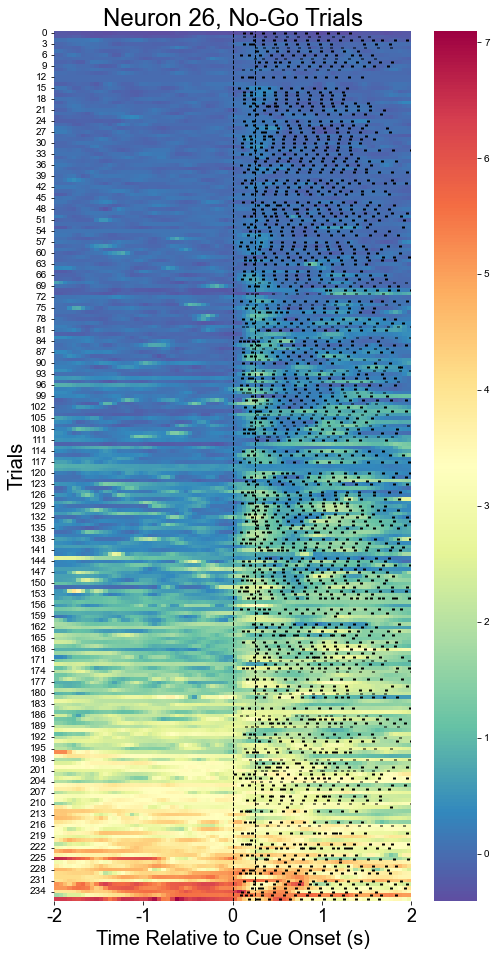

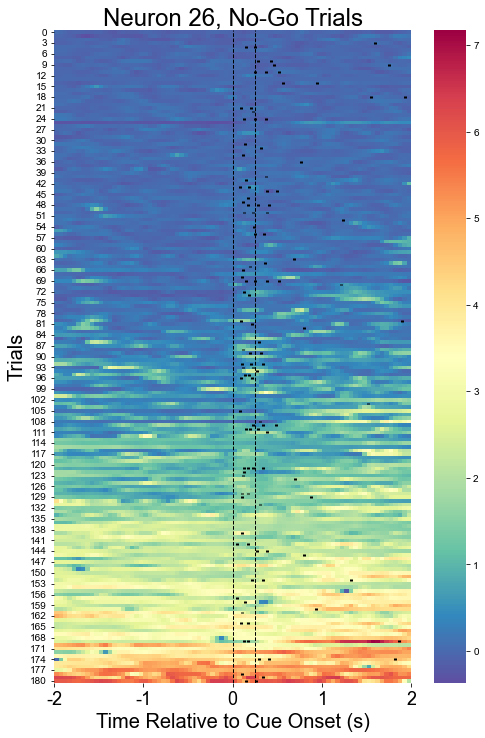

In [18]:
# and plot!
import matplotlib.pyplot as plt
%matplotlib inline
go_trials = plot_heatmap_alltrials(go, dFF_go, 26)
nogo_trials = plot_heatmap_alltrials(nogo, dFF_nogo, 26)

### B. Line plot

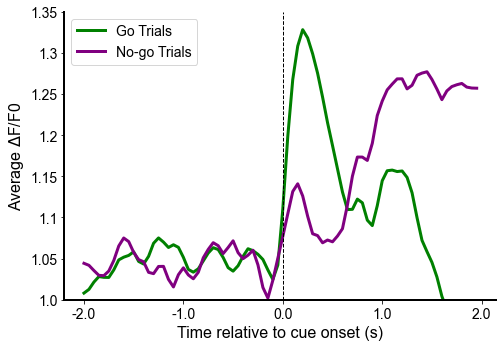

In [19]:
fig = plt.figure(figsize =(6, 4)) 
ax = fig.add_axes([0, 0, 1, 1]) 
plt.plot((np.mean(go_trials[1:],0)), c='green', label='Go Trials')
plt.plot((np.mean(nogo_trials[1:],0)), c='purple', label='No-go Trials')
plt.legend(loc='upper left',prop={'size': 14})
#xticks = [round(num, 2) for num in np.arange(-2.00, 2.05, 1)]
ax.set_xticks(np.arange(0,81,20))
ax.set_xticklabels(np.arange(-2,2.05,1),fontsize=14)
ax.set_yticklabels([round(num, 2) for num in np.arange(1.00, 1.35, 0.05)],fontsize=14)
plt.axvline(40, ls='--', c='k',lw=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Time relative to cue onset (s)',fontsize=16)
plt.ylabel('Average $\Delta$F/F0',fontsize=16)
plt.ylim([1.0, 1.35])
plt.savefig(r"\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\figures\Fig2G.svg", format='svg')
plt.show()

# 6. Other Plots
Older code I wrote to look at each neuron's average response to specific cues

In [195]:
def trials_by_cue(tbt, matrix, cue):
    trials = np.where(tbt["sound_num"] == cue) # this produces an array of an array of a list, which means...
    dFF_by_cue = matrix[:, trials[0], :] # ...we need to index [0] here to reference the list, not the array
    return dFF_by_cue # otherwise we end up with a 4D matrix instead of a 3D matrix

def licks_to_cue(cue):
    cuetrials = behavior[behavior['sound_num']==cue]['adjusted_licks']
    licklist = [item for sublist in cuetrials for item in sublist]
    return licklist

def trials_by_action(tbt, matrix, cue):
    lick = np.where((tbt["sound_num"] == cue) & (tbt["licks_out"] > 0))
    nolick = np.where((tbt["sound_num"] == cue) & (tbt["licks_out"] == 0))
    dFF_lick = matrix[:,lick[0],:]
    dFF_nolick = matrix[:,nolick[0],:]
    return dFF_lick, dFF_nolick

def trials_by_outcome(tbt, matrix):
    rew = np.where(tbt["sound_num"] < 5)
    norew = np.where((tbt["sound_num"] > 4) & (tbt["sound_num"] < 9))
    dFF_rew = matrix[:,rew[0],:]
    dFF_norew = matrix[:,norew[0],:]
    return dFF_rew, dFF_norew

In [21]:
def plotcell_reward(tbt, matrix, cues, neurons):
    time = [round(num, 2) for num in np.arange(-2.00, 2.000, 0.05)]
    sns.set_palette("seismic", n_colors=len(cues))
    for neuron in neurons:
        colors = plt.rcParams["axes.prop_cycle"]()
        fig, axs = plt.subplots(1, 2, sharey='row', sharex=True,  figsize=(12,5))
        for cue in cues:
            if cue < 5:
                ax = 0
            else:
                ax = 1
            current_cue = trials_by_cue(tbt, matrix, cue)
            mean = np.mean(current_cue[:,:,neuron], axis=1)
            sem = scipy.stats.sem(current_cue[:,:,neuron], axis=1, nan_policy='omit')           
            cuecolor = next(colors)["color"]
            axs[ax].plot(time, mean, color=cuecolor, label=('cue ' + str(cue)))
            axs[ax].fill_between(time, (mean-sem), (mean+sem), color=cuecolor, alpha=.5)
            axs[ax].axvline(0, ls='--', c='k',lw=1)
            axs[ax].legend(loc='upper right')
            axs[ax].set_title('neuron' + str(neuron) + "; cue" + str(cue), fontsize=15)
            axs[ax].set_ylabel('dF/F')
            axs[ax].set_xlabel('Time Relative to Cue Onset')

In [186]:
def plotcell(tbt, matrix, cues, neurons):
    time = [round(num, 2) for num in np.arange(-2.00, 2.000, 0.05)]
    sns.set_palette("seismic", n_colors=len(cues))
    for neuron in neurons:
        colors = plt.rcParams["axes.prop_cycle"]()
        fig, axs = plt.subplots(2, len(cues), sharey='row', sharex=True, gridspec_kw={'height_ratios': [1, 2]}, figsize=(12,8))
        cue_counter = 0
        for cue in cues:
            #current_cue = trials_by_cue(tbt, matrix, cue)
            licktrials, nolicktrials = trials_by_action(tbt,matrix,cue)
            mean_lick = np.mean(licktrials[:,:,neuron], axis=1)
            sem_lick = scipy.stats.sem(licktrials[:,:,neuron], axis=1, nan_policy='omit')
            mean_nolick = np.mean(nolicktrials[:,:,neuron], axis=1)
            sem_nolick = scipy.stats.sem(nolicktrials[:,:,neuron], axis=1, nan_policy='omit')            
            cuecolor = next(colors)["color"]
            axs[0,cue_counter].hist(licks_to_cue(cue), color=cuecolor, bins=[round(num, 2) for num in np.arange(-2.00, 2.05, 0.05)])
            axs[1,cue_counter].plot(time, mean_lick, color=cuecolor, label='lick trials')
            axs[1,cue_counter].fill_between(time, (mean_lick-sem_lick), (mean_lick+sem_lick), color=cuecolor, alpha=.5)
            axs[1,cue_counter].plot(time, mean_nolick, color=(0.5, 0.5, 0.5), label='no lick trials')
            axs[1,cue_counter].fill_between(time, (mean_nolick-sem_nolick), (mean_nolick+sem_nolick), color=(0.5, 0.5, 0.5), alpha=.5)
            axs[1,cue_counter].axvline(0, ls='--', c='k',lw=1)
            axs[1,cue_counter].legend(loc='upper right')
            axs[1,cue_counter].set_title('neuron' + str(neuron) + "; cue" + str(cue), fontsize=15)
            axs[0,cue_counter].set_title('Lick Distribution Across Cue ' + str(cue) + ' Trials', fontsize=15)
            axs[1,cue_counter].set_ylabel('dF/F')
            axs[1,cue_counter].set_xlabel('Time Relative to Cue Onset')
            cue_counter += 1

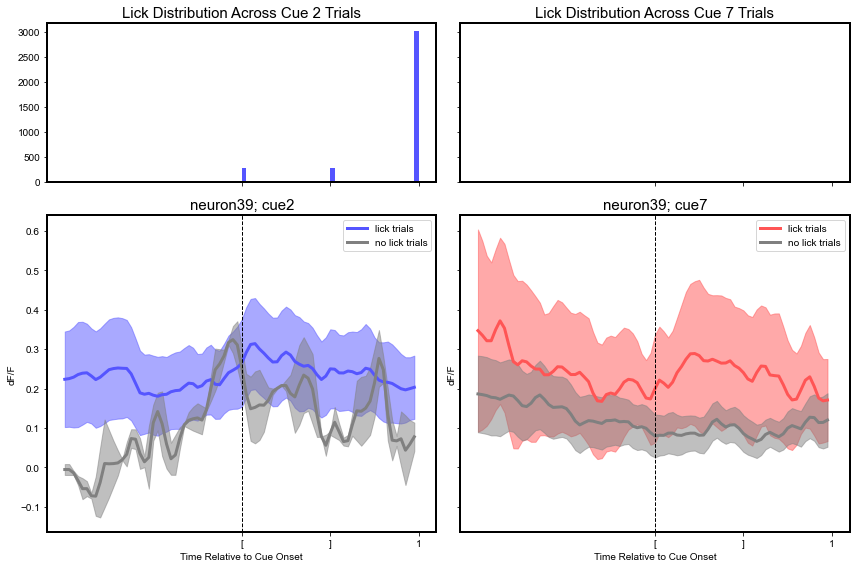

In [361]:
z = plotcell(behavior, dFF_aligned, [2,7], [39])

To see the location in the FOV of a cell of interest, here is a skeleton code. You'll need to compare this code with what's in the Suite2P_Analysis notebook and copy some of that code over here to load in the required files. 

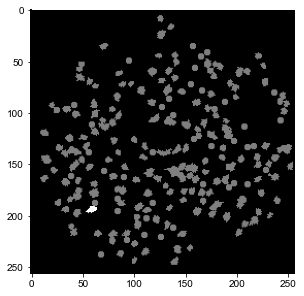

In [99]:
ROI = 146
cellstat = []
for cell in range(gn_seris.Fraw.shape[0]):
    if gn_seris.cells[cell, 0] > 0:
        cellstat.append(gn_seris.stat[cell])
fluoCellPlot = StartPlots()
im = np.zeros((256, 256,3))

for cell in range(len(cellstat)):
    xs = cellstat[cell]['xpix']
    ys = cellstat[cell]['ypix']
    if cell != ROI:
        im[ys, xs] = [0.5, 0.5, 0.5]

    xs = cellstat[ROI]['xpix']
    ys = cellstat[ROI]['ypix']
    im[ys,xs] = np.add(im[ys,xs],[1,1,1])

fluoCellPlot.ax.imshow(im, cmap='CMRmap')
plt.show()

The cells below plot a heatmap of each neuron's average activity, aligned to cue onset.